# Case study: Email clicks


## The problem / the user


We want to make an interactive report/dashboard for advertisement click-through rates on our website. This could just as easily be modified for something like email click rates, but that's the data we have.

We're planning on sending this to our marketing team, who have little to no experience writing code in Python or working with Jupyter notebooks. We don't want to make them install Jupyter, Conda, etc, and we don't want them to navigate big blocks of code. They just need info and visualizations.

In the future, maybe we will want to build a more full-featured app using something like Streamlit, or start from scratch with Flask. For now, though, we want proof-of-concept and we want to iron out the project requirements. This means avoiding additional time spent on developing a web app, etc.

Our marketing team wants to know the following: Who are our users? Which users are clicking on ads? Who would we be targeting?

Our approach with be in providing some interactive visualizations and carrying out some rudimentary clustering.

In [1]:
import pandas as pd
import altair as alt
alt.renderers.enable('mimetype')
%matplotlib inline

# produce vector inline graphics
from IPython.display import set_matplotlib_formats, display, Markdown, HTML

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 4]
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/shubham13p/Ad-Click-Prediction/master/advertising.csv')
df['Click_labeled'] = df['Clicked on Ad'].apply(lambda x: "Click" if x == 1 else "No Click")
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Click_labeled
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,No Click
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,No Click
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,No Click
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,No Click
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,No Click


## Density plots


Let's just take a look at the density plots of a few of these columns. These are like histograms, but smoothed.

This gives us a quick view on distributions within our data. We see the following:

* Most users seem to be around 30 years old, but we have a pretty broad distribution overall .
* We see two "peaks" (or modes) in the daily usage features. This might mean we have two meaningful and distinct usage patterns.
* We'll be interested in age and usage as we continue our investigation of click rates.

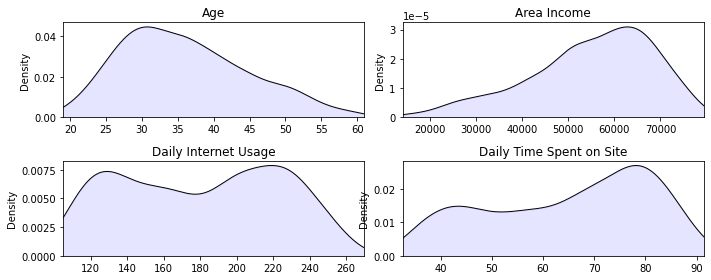

In [3]:
cols = ['Age', 'Area Income', 'Daily Internet Usage', 'Daily Time Spent on Site']

fig, axs = plt.subplots(2, 2)
for ix, col in enumerate(cols):
    row = ix // 2
    column =  ix % 2
    
    plt.tight_layout()
    
    ax = axs[row][column]
    
    
    df[[col]].plot.kde(title=col, 
                       legend=False, 
                       color='black',
                       ax = ax,
                       linewidth=1)
    
    ax.set_xlim(df[col].min(), df[col].max())
    ax.set_ylim(0)
    
    # Get the two lines from the axes to generate shading
    l1 = ax.lines[0]

    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    ax.fill_between(x1,y1, color="blue", alpha=0.1)

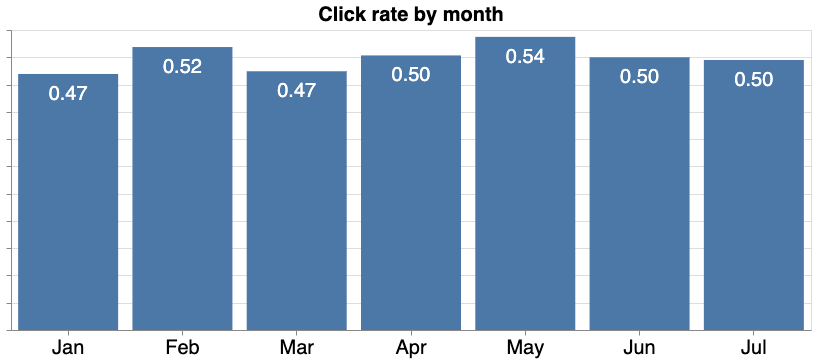

In [4]:
bars = (alt.Chart(df, width=800, title='Click rate by month').mark_bar(width=100)
 .encode(
     alt.X('month(Timestamp):O', title=''),
     y=alt.Y('mean(Clicked on Ad):Q', title='', axis=alt.Axis(labels=False))
 ))
text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=20,
    color='white',
    size=20
).encode(
    text=alt.Text('mean(Clicked on Ad):O', format=('.2f'))
)

(bars + text).configure_axis(labelAngle=0, labelFontSize=20).configure_title(fontSize=20)